In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from researchlib.single_import import *

In [8]:
ctf = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]

# Load dataset
train_loader = FromPublic('cifar10', 'train', batch_size=512, num_workers=8, custom_tf=ctf)
test_loader = FromPublic('cifar10', 'test', batch_size=512, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Model
model = SENet18(input_dim=3)

# Learning
runner = Runner(model, train_loader, test_loader, optimizer='adam', loss_fn='focal')

In [10]:
for _ in range(3): runner.fit_onecycle(1e-3, mixup_alpha=0.4)

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1        12.4314        0.3586        7.8800        0.5683    



  Epochs    train_loss    train_acc      val_loss      val_acc    
    1         9.7532        0.5120        5.8361        0.6877    



  Epochs    train_loss    train_acc      val_loss      val_acc    
    1         8.7946        0.5782        5.2004        0.7167    



In [11]:
runner.fit_cycle(5, 1e-3, mixup_alpha=0.4)

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1         8.1843        0.6115        4.3897        0.7788    


    2         7.4503        0.6526        4.0888        0.7923    


    3         7.2631        0.6683        3.5816        0.8257    


    4         7.2627        0.6723        5.0901        0.7691    


    5         6.3982        0.7144        3.1725        0.8362    


    6         6.3257        0.7239        2.9517        0.8609    


    7         6.5426        0.7044        3.7647        0.8220    


    8         6.0122        0.7357        3.1717        0.8400    


    9         5.7999        0.7457        2.6071        0.8755    


    10        5.7873        0.7456        2.3910        0.8839    


    11        6.1366        0.7327        2.9834        0.8521    


    12        5.9950        0.7314        2.7209        0.8628    


    13        5.5786        0.7543        2.4553        0.8793    


    14        5.5896        0.7521        2.3004        0.8976    


    15        5.5203        0.7552        2.0562        0.9027    



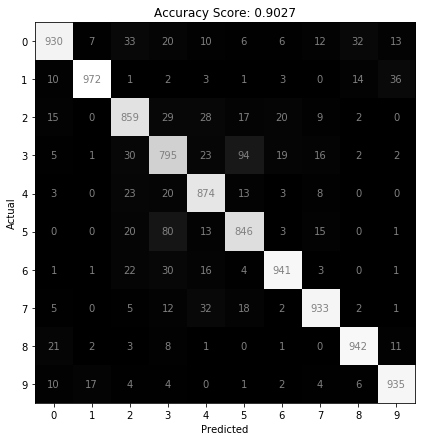

In [12]:
runner.validate(metrics=[ConfusionMatrix(plot=True, classes=10)])

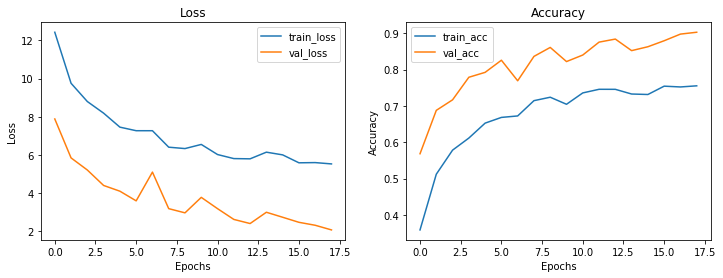

In [13]:
runner.history(plot=True)